In [1]:
import numpy as np
import pandas as pd
import random

# Generator

In [2]:
def buildStableSignal(fisrtSignal, pri, variance = 1, thresholdBuffer = 10000):
    buffer = list()
    newPulse = fisrtSignal
    count = 0
    
    while newPulse < thresholdBuffer:
        buffer.append(newPulse)
        count += 1
        newPulse = fisrtSignal + count * pri
                
    deviationBuffer = np.random.normal(0, 1, len(buffer)) * variance
    deviationBuffer[0] = 0
    
    info = (fisrtSignal, pri, deviationBuffer.std())
    
    deviationBuffer = [round(num) for num in deviationBuffer]
    buffer = np.add(buffer, deviationBuffer).tolist()
        
    return buffer, info

In [3]:
# Use case 
# stableSignalBuffer, info = buildStableSignal(15, 30)

In [4]:
def buildStaggerSignal(fisrtSignal, pris, variance = 1, thresholdBuffer = 10000):
    buffer = list()
    newPulse = fisrtSignal
    count = 0
    
    while newPulse < thresholdBuffer:
        buffer.append(newPulse)
        newPulse += pris[count%len(pris)]
        count += 1
        
    deviationBuffer = np.random.normal(0, 1, len(buffer)) * variance
    deviationBuffer[0] = 0
    
    info = (fisrtSignal, pris, deviationBuffer.std())
    
    deviationBuffer = [round(num) for num in deviationBuffer]
        
    return np.add(buffer, deviationBuffer).tolist(), info

In [5]:
# Use case 
# staggerSignalBuffer, info = buildStaggerSignal(15, [30, 80])

In [6]:
def buildJitterSignal(fisrtSignal, pri, jitter, variance = 1, thresholdBuffer = 10000):
    buffer = list()
    newPulse = fisrtSignal
    count = 0
    
    while newPulse < thresholdBuffer:
        buffer.append(newPulse)
        count += 1
        newPulse = fisrtSignal + count * pri
                
    deviationBuffer = np.random.normal(0, 1, len(buffer)) * variance
    deviationBuffer[0] = 0
    
    jitterBuffer = np.random.uniform(-1, 1, len(buffer)) * (jitter/100) * pri
    jitterBuffer[0] = 0
    deviationAndJitterBuffer = np.add(deviationBuffer, jitterBuffer)
    
    info = (fisrtSignal, pri, deviationAndJitterBuffer.std())
    
    deviationAndJitterBuffer = [round(num) for num in deviationAndJitterBuffer]
    buffer = np.add(buffer, deviationAndJitterBuffer).tolist()
        
    return buffer, info

In [7]:
# Use case 
# jitterSignalBuffer, info = buildJitterSignal(50, 100, 8)

In [8]:
def buildBuffer(stables, staggers, jitters):
    buffer = list()
    info = dict()
    
    info['stable'] = list()
    info['stagger'] = list()
    info['jitter'] = list()
    
    for stable in stables:
        tempBuffer, tempInfo = buildStableSignal(stable[0], stable[1], stable[2], stable[3]) ####
        buffer.extend(tempBuffer)
        info['stable'].append(tempInfo)
        
        
    for stagger in staggers:
        tempBuffer, tempInfo = buildStaggerSignal(stagger[0], stagger[1], stagger[2], stagger[3]) ####
        buffer.extend(tempBuffer)
        info['stagger'].append(tempInfo)
    
    for jitter in jitters:
        tempBuffer, tempInfo = buildJitterSignal(jitter[0], jitter[1], jitter[2], jitter[3], jitter[4]) ####
        buffer.extend(tempBuffer)
        info['jitter'].append(tempInfo)
    
    
    buffer.sort()
    
    return buffer, info

In [9]:
import matplotlib.pyplot as plt

def plot_grafico(valores, barras_vermelhas=[], title='Signal'):
    if isinstance(title, float):
        title = f"{title:.2f}"
    
    plt.figure(figsize=(15, 2))
    
    # Definindo as cores de cada barra
    cores = ['red' if val in barras_vermelhas else 'blue' for val in valores]
    
    altura_fixa = 5
    plt.bar(valores, [altura_fixa] * len(valores), width=10, align='center', color=cores)
    
    plt.xticks(valores, rotation=90, fontsize=13)
    plt.ylim(0, 10)
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()

# Solver

## PRIL

In [31]:
pd.read_excel("T_PRIL.xlsx", names=['lower bound', 'upper bound', 'window'])

,lower bound,upper bound,window
0,10,18,2
1,20,36,2
2,20,36,4
3,38,70,2
4,38,70,8
5,72,136,3
6,72,136,16
7,139,267,3
8,139,267,32
9,269,525,3


In [103]:
def PRILApply(originalBuffer, pathToPrilFile='T_PRIL.xlsx'):
    
    buffer = originalBuffer.copy()
    PRIL = pd.read_excel("T_PRIL.xlsx", names=['lower bound', 'upper bound', 'window'])
    
    # Estabelecendo as variáveis para busca
    indice_buffer = 0  # Índice do pulso atual para busca no buffer

    # Inicializando variáveis vazias para trabalhar com elas no script
    primeiros_PPI_possiveis = []
    proximos_PPI_condizentes = []
    ameacas_encontradas = []

    qtd_pulsos_buffer = len(buffer)  # Número de pulsos no buffer

    for index, row in PRIL.iterrows():

        # Buffer menor que tamanho mínimo de busca
        if qtd_pulsos_buffer < 5:
            break

        # Intervalo e janela da n-ésima linha do PRIL
        limite_inferior_intervalo_linha_PRIL = row['lower bound']
        limite_superior_intervalo_linha_PRIL = row['upper bound']
        janela_linha_PRIL = row['window']

        # Buscas dentro de buffer com índice i como parâmetro
        while indice_buffer <= (qtd_pulsos_buffer - 4):
            # Varrendo buffer comparando ao PRIL
            for j in range(indice_buffer + 1, qtd_pulsos_buffer - 3):
                # Seja esta a diferença PPI1 ...
                Dif = buffer[j] - buffer[indice_buffer]
                # PPI1 está no intervalo do PRIL?
                if (limite_inferior_intervalo_linha_PRIL - janela_linha_PRIL <= Dif <= limite_superior_intervalo_linha_PRIL + janela_linha_PRIL):
                    # Se sim, salve-a em um vetor com os TOAs
                    primeiros_PPI_possiveis.append(Dif)
                if Dif > limite_superior_intervalo_linha_PRIL + janela_linha_PRIL:
                    break
            # Se for não vazio, foi achado ao menos um termo
            if primeiros_PPI_possiveis:
                # Tem-se em PPIS1 todos os TOAs possíveis desse intervalo
                for p in range(len(primeiros_PPI_possiveis)):
                    # Para cada TOA em PPIS1, buscar-se-á o subsequente em buffer
                    for j in range(indice_buffer + 2, qtd_pulsos_buffer - 1):
                        # Seja esta a diferença PPI2 ...
                        Dif = buffer[j] - buffer[indice_buffer]
                        # PPI2 está no mesmo intervalo de PPI1 novamente?
                        if (2 * primeiros_PPI_possiveis[p] - janela_linha_PRIL <= Dif <= 2 * primeiros_PPI_possiveis[p] + janela_linha_PRIL):
                            # Se sim, salve-a em um vetor com os TOAs
                            proximos_PPI_condizentes.append(Dif - primeiros_PPI_possiveis[p])
                        if Dif > 2 * primeiros_PPI_possiveis[p] + janela_linha_PRIL:
                            break
                    # Se for não vazio, foi achado ao menos um novo termo
                    if proximos_PPI_condizentes:
                        # Tem-se em PPIS2 todos os TOAs possíveis novamente
                        for q in range(len(proximos_PPI_condizentes)):
                            # Inicializando variáveis contadoras
                            contador = [0, 0, 0]
                            PPI345 = [0, 0, 0]
                            dev345 = [0, 0, 0]
                            # Varrendo buffer para confirmação de PRI
                            for r in range(3, 6):
                                # Serão necessários 3 rounds de confirmação
                                # Busca por todo o buffer em cada uma delas
                                for j in range(indice_buffer + 3, qtd_pulsos_buffer):
                                    Dif = buffer[j] - buffer[indice_buffer]
                                    # Se dentro do intervalo e janela
                                    # Utilizei Wdw*0.67 por conta da média
                                    if ((r * np.mean([primeiros_PPI_possiveis[p], proximos_PPI_condizentes[q]]) - janela_linha_PRIL <= Dif)
                                        and (Dif <= (r * np.mean([primeiros_PPI_possiveis[p], proximos_PPI_condizentes[q]]) + janela_linha_PRIL))):
                                        # Vai salvar o k correspondente
                                        contador[r - 3] += 1
                                        # Salva a PPI da posição
                                        PPI345[r - 3] = Dif / r
                                        # Salva o deviation
                                        dev345[r - 3] = abs(PPI345[r - 3] - np.mean([primeiros_PPI_possiveis[p], proximos_PPI_condizentes[q]]))
                                    else:
                                        # Quando maior que o intervalo + janela
                                        if Dif > (r * np.mean([primeiros_PPI_possiveis[p], proximos_PPI_condizentes[q]]) + janela_linha_PRIL):
                                            # Interrompe o for do buffer
                                            break
                                # Se a primeira confirmação não der resultado
                                if contador[0] == 0:
                                    # Interrompe a busca
                                    break
                            # Caso tenha ao menos 2 elementos de k != 0
                            if sum(np.array(contador) != 0) >= 2:
                                PRI = [primeiros_PPI_possiveis[p], proximos_PPI_condizentes[q]] + PPI345
                                PRIMean = np.mean([x for x in PRI if x != 0])

                                DEV = [(proximos_PPI_condizentes[q] - primeiros_PPI_possiveis[p])] + dev345
                                TREM = [buffer[indice_buffer], np.mean([x for x in PRI if x != 0]), np.std([x for x in DEV if x != 0])]
                                ameacas_encontradas.append(TREM)
                                if len(ameacas_encontradas) > 1:
                                    # Encontrar índices de PRIs múltiplos
                                    minimo_ameaca = min([x[1] for x in ameacas_encontradas if x != 0])
                                    print(ameacas_encontradas) ####################3
                                    maxMultiplo_PRI = TREM[1] / minimo_ameaca
                                    #maxMultiplo_PRI = TREM[1] / min([x for x in ameacas_encontradas if x != 0], key=lambda x: x[1])
                                    indice_PRI_Multiplos = []
                                    for i in range(1, int(maxMultiplo_PRI) + 1):
                                        multiploAtual = TREM[1] / i
                                        indice_PRI_Multiplos = [x for x in indice_PRI_Multiplos if abs(ameacas_encontradas[x][1] - multiploAtual) <= janela_linha_PRIL]
                                    indice_PRI_Multiplos = [x for x in indice_PRI_Multiplos if x != len(ameacas_encontradas)]
                                    if indice_PRI_Multiplos:
                                        # Remover as linhas correspondentes das ameaças
                                        ameacas_encontradas.pop()
                                # Apagar TOAs congruentes
                                # Poderia-se definir uma tolerância de X%
                                # Zerando os valores em buffer que são próximos o suficiente de TREM
                                indexador = 0
                                while (TREM[0] + indexador * np.mean([x for x in PRI if x != 0])) <= max(buffer):
                                    # Calculando a Diferença entre os termos e os elementos de buffer
                                    Dif = np.abs(np.array(buffer) - (TREM[0] + indexador * np.mean([x for x in PRI if x != 0])))
                                    # Encontrando os índices dos elementos de dentro de (janela_linha_PRIL*0.34)
                                    Ind = np.where(Dif <= janela_linha_PRIL)[0]
                                    # Remove os elementos encontrados de buffer
                                    #plot_grafico([buffer[i] for i in Ind]) ########
                                    buffer = [x for i, x in enumerate(buffer) if i not in Ind]
                                    indexador += 1
                                # PRI ok, Salvo e Apagado!
                                qtd_pulsos_buffer = len(buffer)
                                # Novo tamanho de buffer
                                indice_buffer = 0
                                # Voltando ao i=1 porque apaguei o mesmo
                            # Caso confirmação falhar
                        # Caso confirmação falhar
                    # Acabada a busca dos PPIs condizentes
                    proximos_PPI_condizentes = []
                    PPI345 = [0, 0, 0]
                    dev345 = [0, 0, 0]
                # Caso PPIs condizentes vazio
                # Caso PPIs condizentes vazio
                primeiros_PPI_possiveis = []
                proximos_PPI_condizentes = []
                PPI345 = [0, 0, 0]
                dev345 = [0, 0, 0]
            # Caso PPIs possiveis vazio
            indice_buffer += 1
        # Caso em que terminaram as buscas para essa linha do PRIL
        indice_buffer = 0

    # Caso em que não há mais n para buscar no PRIL
#     for ameaca in ameacas_encontradas:
#         print(ameaca)
    return ameacas_encontradas


# Use Case

## Buffer

In [104]:
stables = [[15, 50, 1, 10000], [25, 75, 1, 10000]] # [[15, 50, 1, 10000], [25, 75, 1, 10000]] # [[fisrtSignal, pri, variance = 1, thresholdBuffer = 10000]]
staggers = [[20, [65, 105, 230], 1, 10000]] # [[fisrtSignal, pris, variance = 1, thresholdBuffer = 10000]]
jitters = [[110, 600, 16, 1, 10000]] # = [[], []]  # [[fisrtSignal, pri, jitter, variance = 1, thresholdBuffer = 10000]]

In [105]:
buffer, info = buildBuffer(stables, staggers, jitters)

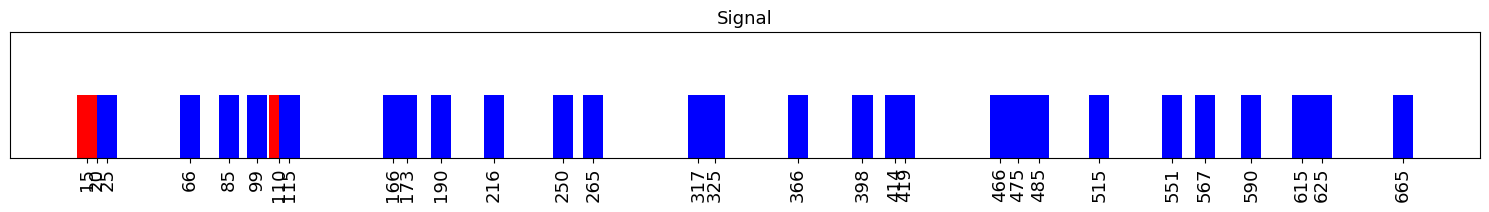

In [106]:
plot_grafico(buffer[:30], [20, 15, 110])

In [107]:
threats = PRILApply(buffer)

[[849, 38.416666666666664, 0.34246744460938844], [475, 37.96666666666667, 2.0831481399169647]]
[[849, 38.416666666666664, 0.34246744460938844], [475, 37.96666666666667, 2.0831481399169647], [1676, 37.243333333333325, 1.9901973310872125]]
[[849, 38.416666666666664, 0.34246744460938844], [475, 37.96666666666667, 2.0831481399169647], [1676, 37.243333333333325, 1.9901973310872125], [5315, 37.17333333333333, 1.0802198850234155]]
[[849, 38.416666666666664, 0.34246744460938844], [475, 37.96666666666667, 2.0831481399169647], [1676, 37.243333333333325, 1.9901973310872125], [5315, 37.17333333333333, 1.0802198850234155], [8952, 37.104166666666664, 2.1085510793720377]]
[[849, 38.416666666666664, 0.34246744460938844], [475, 37.96666666666667, 2.0831481399169647], [1676, 37.243333333333325, 1.9901973310872125], [5315, 37.17333333333333, 1.0802198850234155], [8952, 37.104166666666664, 2.1085510793720377], [15, 50.11666666666667, 1.0808375810190962]]
[[849, 38.416666666666664, 0.34246744460938844], [4

In [76]:
threats

[[4376, 37.410000000000004, 0.01249999999999929],
 [6589, 37.083333333333336, 1.1666666666666679],
 [7714, 36.38333333333334, 0.48888888888888715],
 [9249, 38.041666666666664, 1.0555555555555547],
 [475, 37.78333333333333, -0.9722222222222214],
 [2875, 38.28333333333333, 0.10416666666666607],
 [3215, 36.28333333333333, 0.5666666666666664],
 [1665, 50.0, nan],
 [15, 49.85666666666667, 0.19583333333333464],
 [25, 74.97333333333333, 2.8444444444444437],
 [86, 399.8166666666667, 0.9111111111110972]]

In [63]:
info

{'stable': [(15, 50, 1.0319696505663165), (25, 75, 1.001821082855237)],
 'stagger': [(20, [65, 105, 230], 1.054359276305735)],
 'jitter': [(110, 600, 41.83923353184827)]}

In [64]:
info['stable']

[(15, 50, 1.0319696505663165), (25, 75, 1.001821082855237)]

In [65]:
info['stagger']

[(20, [65, 105, 230], 1.054359276305735)]

In [49]:
info['jitter']

[(110, 600, 50.24907496612409)]